<a href="https://colab.research.google.com/github/jithinprakashk/Bike_Rent_Linear_Regression/blob/main/Bridgeweave_test_Jithin_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Solution

## Import libraries

In [1]:
import warnings 
warnings.filterwarnings('ignore')

In [54]:
import pandas as pd
import numpy as np
import datetime as dt
import calendar
import seaborn as sns
import matplotlib.pyplot as plt
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error

## Read and understand the data

##### **Reading data from Google Drive**

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


##### **Unzipping archive**

In [4]:
!unzip -o '/content/gdrive/MyDrive/tests/Bridgeweave/Assignment'

Archive:  /content/gdrive/MyDrive/tests/Bridgeweave/Assignment.zip
  inflating: Problem Statement.pdf   
   creating: data/
  inflating: data/customers.csv      
  inflating: data/pings.csv          
  inflating: data/.DS_Store          
  inflating: data/test.csv           
  inflating: data/Data Description.pdf  


##### **Loading data to DataFrame**

In [5]:
df_pings = pd.read_csv('/content/data/pings.csv')

In [6]:
df_customers = pd.read_csv('/content/data/customers.csv')

##### **Head of dataframes**

In [7]:
df_pings.head()

,id,timestamp
0,899313,1496278800
1,373017,1496278800
2,798984,1496278800
3,245966,1496278800
4,689783,1496278800


In [8]:
df_customers.head()

,id,gender,age,number_of_kids
0,979863,MALE,26,2
1,780123,MALE,60,2
2,614848,MALE,45,4
3,775046,MALE,62,3
4,991601,MALE,23,0


##### **Shape of datasets**

In [9]:
df_pings.shape

(50528701, 2)

In [10]:
df_customers.shape

(2500, 4)

##### **Info**

In [11]:
df_pings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50528701 entries, 0 to 50528700
Data columns (total 2 columns):
 #   Column     Dtype
---  ------     -----
 0   id         int64
 1   timestamp  int64
dtypes: int64(2)
memory usage: 771.0 MB


In [12]:
df_customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              2500 non-null   int64 
 1   gender          2500 non-null   object
 2   age             2500 non-null   int64 
 3   number_of_kids  2500 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 78.2+ KB


##### **Converting epoch time to datetime**

In [13]:
df_pings['date_time'] = pd.to_datetime(df_pings.timestamp, unit = 's')
df_pings.head()

,id,timestamp,date_time
0,899313,1496278800,2017-06-01 01:00:00
1,373017,1496278800,2017-06-01 01:00:00
2,798984,1496278800,2017-06-01 01:00:00
3,245966,1496278800,2017-06-01 01:00:00
4,689783,1496278800,2017-06-01 01:00:00


##### **Analzing the time interval for id 899313**

In [14]:
df_pings[df_pings.id==899313].sort_values('date_time').head(10)

,id,timestamp,date_time
0,899313,1496278800,2017-06-01 01:00:00
8,899313,1496278815,2017-06-01 01:00:15
16,899313,1496278830,2017-06-01 01:00:30
25,899313,1496278845,2017-06-01 01:00:45
34,899313,1496278860,2017-06-01 01:01:00
48,899313,1496278875,2017-06-01 01:01:15
60,899313,1496278890,2017-06-01 01:01:30
73,899313,1496278905,2017-06-01 01:01:45
85,899313,1496278920,2017-06-01 01:02:00
109,899313,1496278935,2017-06-01 01:02:15


- It is observed that the the ping interval is 15 seconds, ie each ping lasts for 15 seconds.
- Each ping is taken as online activity for 15 seconds.
- Total pings times 15 seconds gives the online duration

##### **Converting date time to date**

In [15]:
df_pings['date']=pd.to_datetime(df_pings.date_time.dt.date)

In [16]:
df_pings.head()

,id,timestamp,date_time,date
0,899313,1496278800,2017-06-01 01:00:00,2017-06-01
1,373017,1496278800,2017-06-01 01:00:00,2017-06-01
2,798984,1496278800,2017-06-01 01:00:00,2017-06-01
3,245966,1496278800,2017-06-01 01:00:00,2017-06-01
4,689783,1496278800,2017-06-01 01:00:00,2017-06-01


##### **Grouping with respect to date and calculating hours**


> A  ping is taken as a 15 second duration



In [17]:
df_ping_grp = round (15/3600 * df_pings.groupby(['id','date'])[['date_time']].count(),0)
df_ping_grp.reset_index(inplace=True)
df_ping_grp.columns = ['id','date','hours']
df_ping_grp.head()

,id,date,hours
0,111556,2017-06-01,2.0
1,111556,2017-06-02,2.0
2,111556,2017-06-05,4.0
3,111556,2017-06-06,3.0
4,111556,2017-06-07,2.0


##### **Shape of the grouped data frame**

In [18]:
df_ping_grp.shape

(41676, 3)

##### **Merging customer dataframe**

In [19]:
df_merged = pd.merge(df_ping_grp,df_customers,'inner',on='id')
df_merged['weekday']= df_merged['date'].dt.weekday
df_merged.head()

,id,date,hours,gender,age,number_of_kids,weekday
0,111556,2017-06-01,2.0,FEMALE,49,4,3
1,111556,2017-06-02,2.0,FEMALE,49,4,4
2,111556,2017-06-05,4.0,FEMALE,49,4,0
3,111556,2017-06-06,3.0,FEMALE,49,4,1
4,111556,2017-06-07,2.0,FEMALE,49,4,2


##### **Shape of the merged dataframe**

In [20]:
df_merged.shape

(41738, 7)

##### **Info**

In [21]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41738 entries, 0 to 41737
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   id              41738 non-null  int64         
 1   date            41738 non-null  datetime64[ns]
 2   hours           41738 non-null  float64       
 3   gender          41738 non-null  object        
 4   age             41738 non-null  int64         
 5   number_of_kids  41738 non-null  int64         
 6   weekday         41738 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 2.5+ MB


##### **Unique categories**

In [22]:
df_merged.nunique()

id                2480
date                22
hours               19
gender               2
age                 58
number_of_kids       5
weekday              7
dtype: int64

**Date Range**

In [23]:
df_merged.date.sort_values()

0       2017-06-01
6430    2017-06-01
30664   2017-06-01
30649   2017-06-01
6444    2017-06-01
           ...    
3977    2017-06-22
31641   2017-06-22
29045   2017-06-22
13275   2017-06-22
41737   2017-06-22
Name: date, Length: 41738, dtype: datetime64[ns]

## Data Visualization

### Line plots

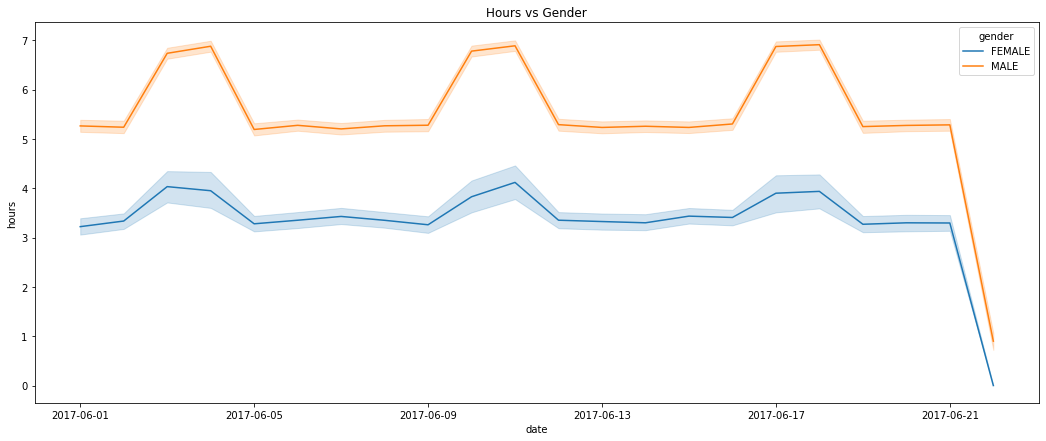

In [24]:
plt.figure(figsize=(18,7))
sns.lineplot(x='date',y='hours',hue='gender',data=df_merged)
plt.title('Hours vs Gender')
plt.show()

- Males have a higher online duration compared to females

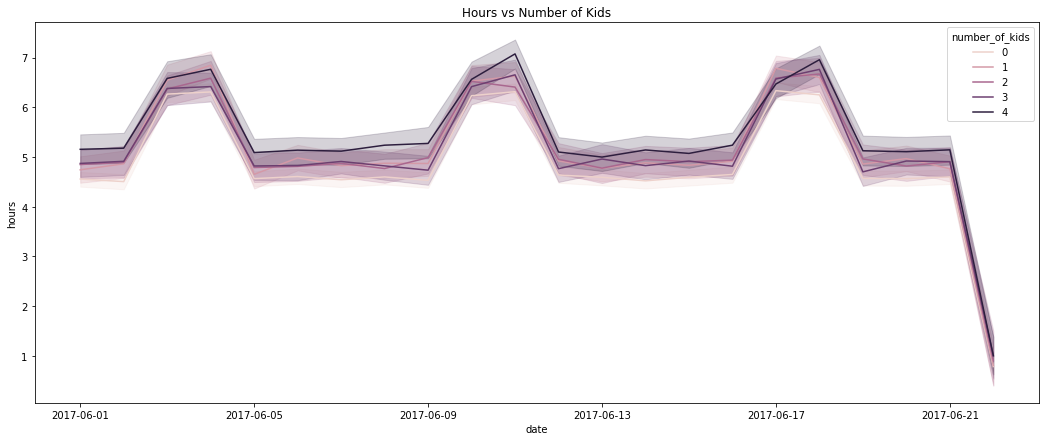

In [25]:
plt.figure(figsize=(18,7))
sns.lineplot(x='date',y='hours',hue='number_of_kids',data=df_merged)
plt.title('Hours vs Number of Kids')
plt.show()

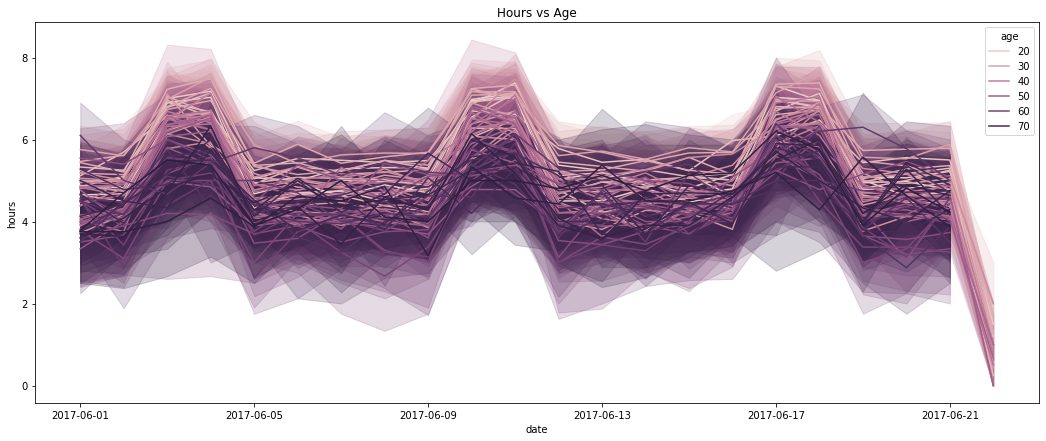

In [26]:
plt.figure(figsize=(18,7))
sns.lineplot(x='date',y='hours',hue='age',data=df_merged)
plt.title('Hours vs Age')
plt.show()

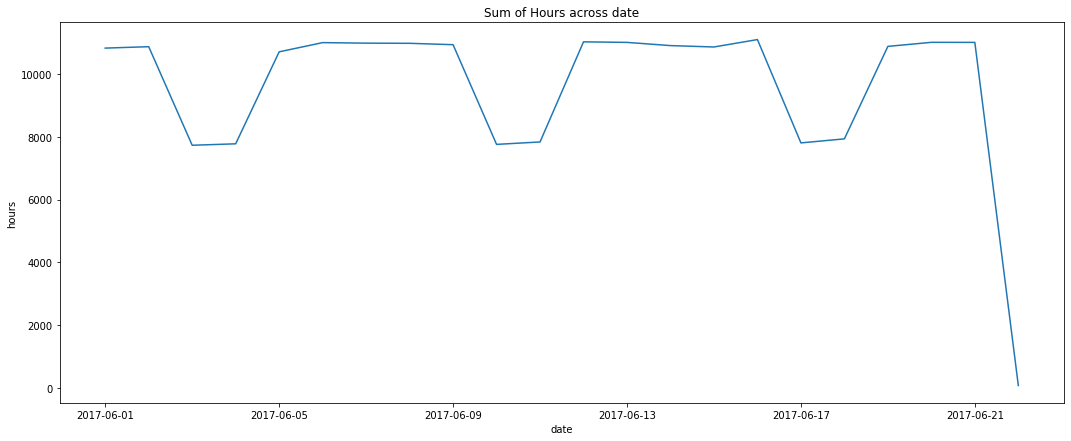

In [27]:
plt.figure(figsize=(18,7))
sns.lineplot(x='date',y='hours',data=df_merged.groupby('date')['hours'].sum().sort_values().reset_index())
plt.title('Sum of Hours across date')
plt.show()

- Weekdays less duration online from entire dataset

### Boxplots

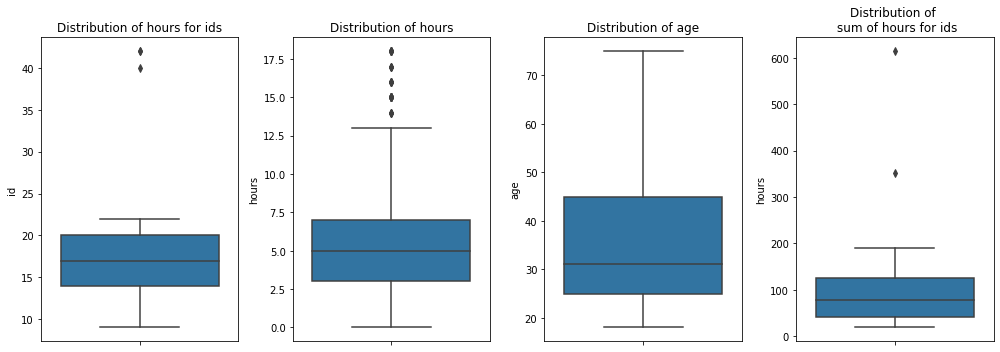

In [28]:
plt.figure(figsize=(14,5))
plots = 4

plt.subplot(1,plots,1)
sns.boxplot(y = df_merged.id.value_counts())
plt.title('Distribution of hours for ids')

plt.subplot(1,plots,2)
sns.boxplot(y='hours',data=df_merged)
plt.title('Distribution of hours')

plt.subplot(1,plots,3)
sns.boxplot(y='age',data=df_merged)
plt.title('Distribution of age')

plt.subplot(1,plots,4)
sns.boxplot(y = df_merged.groupby('id')['hours'].sum())
plt.title('Distribution of \n sum of hours for ids')

plt.tight_layout()
plt.show()

- There are few ids with high number of total online hours - (outliers)
- There are few ids that has high number of pings - (outliers)

**Outliers**

In [29]:
df_merged.id.value_counts().head(8)

799250    42
320227    42
800600    40
489021    22
480466    22
816570    22
736158    22
431277    22
Name: id, dtype: int64

- Ids ```799250, 320227 and 800600``` have mode number of pings    

In [30]:
df_merged.groupby('id')['hours'].sum().sort_values(ascending=False).head(8)

id
320227    614.0
800600    352.0
799250    190.0
627176    187.0
919150    183.0
232551    179.0
671320    178.0
347061    177.0
Name: hours, dtype: float64

- Ids ```320227 and 800600``` have accessed the app more number of hours   

### Count plots

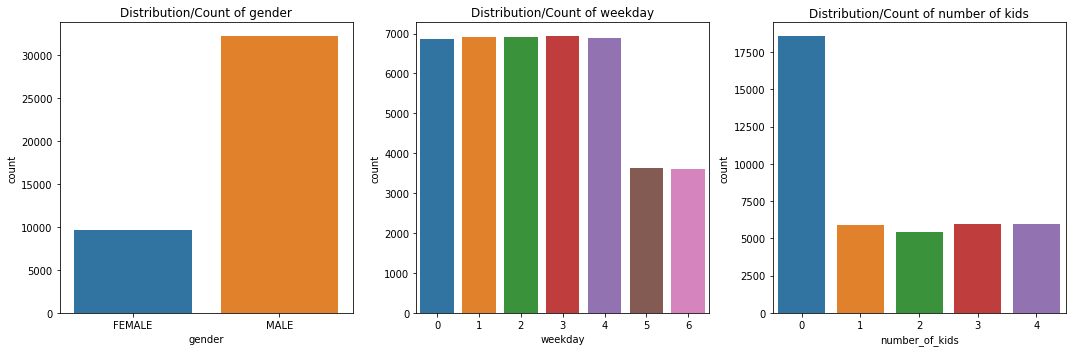

In [31]:
plt.figure(figsize=(15,5))
plots = 3

plt.subplot(1,plots,1)
sns.countplot(x='gender',data=df_merged)
plt.title('Distribution/Count of gender')

plt.subplot(1,plots,2)
sns.countplot(x='weekday',data=df_merged)
plt.title('Distribution/Count of weekday')

plt.subplot(1,plots,3)
sns.countplot(x='number_of_kids',data=df_merged)
plt.title('Distribution/Count of number of kids')

plt.tight_layout()
plt.show()

- Males are more in the dataset compared to females
- Number of pings in weekends are less. 0=Monday and 6=Sunday
- Number of customers with no children are with most number of pings/sessions

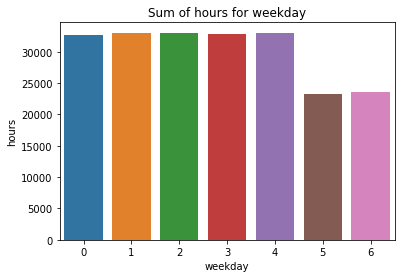

In [32]:
sns.barplot(x='weekday',y='hours',data=df_merged.groupby('weekday')['hours'].sum().reset_index())
plt.title('Sum of hours for weekday')
plt.show()

- Total duration in weekends are less. 0=Monday and 6=Sunday

### Bivariate box plots

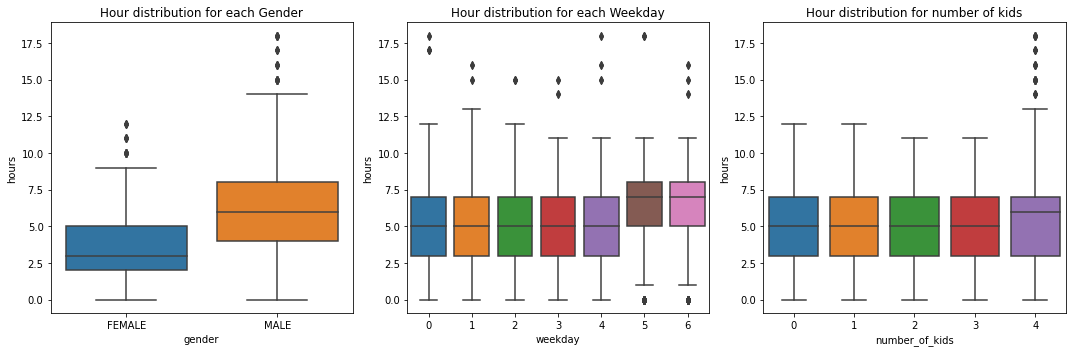

In [33]:
plt.figure(figsize=(15,5))
plots = 3

plt.subplot(1,plots,1)
sns.boxplot(x='gender',y='hours',data=df_merged)
plt.title('Hour distribution for each Gender')

plt.subplot(1,plots,2)
sns.boxplot(x='weekday',y='hours',data=df_merged)
plt.title('Hour distribution for each Weekday')

plt.subplot(1,plots,3)
sns.boxplot(x='number_of_kids',y='hours',data=df_merged)
plt.title('Hour distribution for number of kids')

plt.tight_layout()
plt.show()

- Males have a higher distribtion compared to females
- Weekends shows more number of hours compared to weekdays, however total hours seems to be low. the box is smaller is size.
- Number of kids donot show any trend


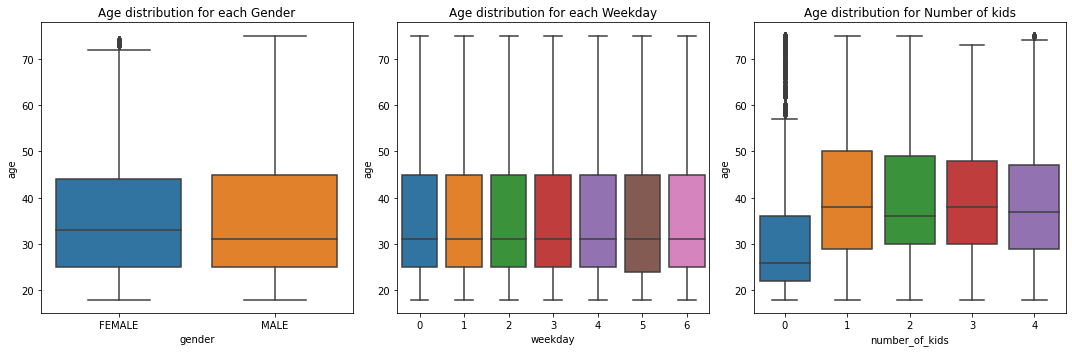

In [34]:
plt.figure(figsize=(15,5))
plots = 3

plt.subplot(1,plots,1)
sns.boxplot(x='gender',y='age',data=df_merged)
plt.title('Age distribution for each Gender')

plt.subplot(1,plots,2)
sns.boxplot(x='weekday',y='age',data=df_merged)
plt.title('Age distribution for each Weekday')

plt.subplot(1,plots,3)
sns.boxplot(x='number_of_kids',y='age',data=df_merged)
plt.title('Age distribution for Number of kids')

plt.tight_layout()
plt.show()

- Females and males show similar distribution with respect to age.
- The hours spend on days show similar trend for different age
- Number of kids are nil for customers with less age 25-35years

##### **Scatter plot**

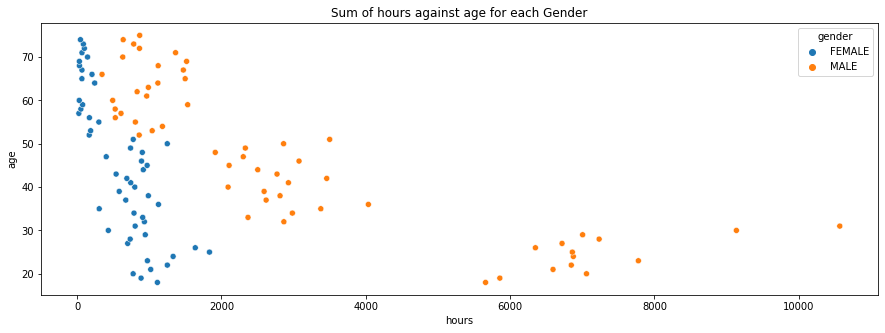

In [35]:
plt.figure(figsize=(15,5))
sns.scatterplot(x='hours',y='age',hue='gender',data=df_merged.groupby(['age','gender'])['hours'].sum().reset_index())
plt.title('Sum of hours against age for each Gender')
plt.show()

- Total hours spent by mailes are much higher compared to females

### Correlation check

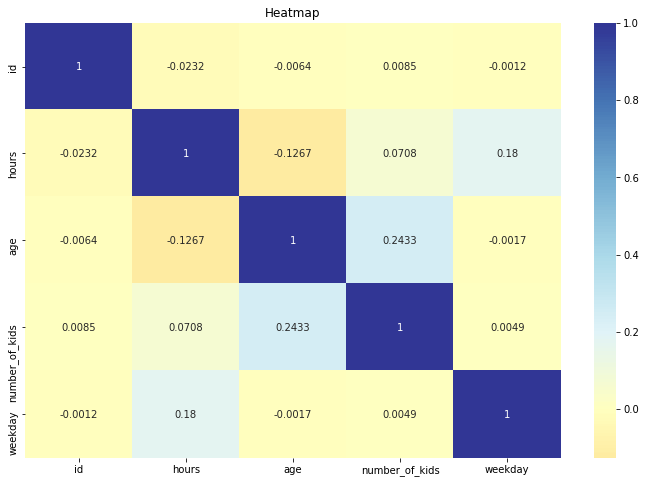

In [36]:
plt.figure(figsize=(12,8))
sns.heatmap(df_merged.corr().round(4),fmt='g',annot=True,cmap='RdYlBu',center=0)
plt.title('Heatmap')
plt.show()

- No correlation between the variables

## Model building

### FBProphet

In [37]:
df_merged.head()

,id,date,hours,gender,age,number_of_kids,weekday
0,111556,2017-06-01,2.0,FEMALE,49,4,3
1,111556,2017-06-02,2.0,FEMALE,49,4,4
2,111556,2017-06-05,4.0,FEMALE,49,4,0
3,111556,2017-06-06,3.0,FEMALE,49,4,1
4,111556,2017-06-07,2.0,FEMALE,49,4,2


**Preprocessing the data**

In [38]:
df = df_merged.drop(columns=['weekday'])
df.gender = df.gender.map({'FEMALE':0,'MALE':1})
df.columns = ['id','ds','y','gender','age','nkids']
df.head() 

,id,ds,y,gender,age,nkids
0,111556,2017-06-01,2.0,0,49,4
1,111556,2017-06-02,2.0,0,49,4
2,111556,2017-06-05,4.0,0,49,4
3,111556,2017-06-06,3.0,0,49,4
4,111556,2017-06-07,2.0,0,49,4


**Predicting for each id using FBProphet**

In [39]:
final = pd.DataFrame()
grouped = df.groupby('id')
tot_grps = len(grouped.groups)
for i,g in enumerate(grouped.groups):
    group = grouped.get_group(g)
    m = Prophet(daily_seasonality=True,yearly_seasonality=False)
    m.fit(group)
    future = m.make_future_dataframe(periods=7)
    forecast = m.predict(future)
    forecast['id'] = g
    forecast=forecast[['id','ds','yhat']]
    forecast =forecast.round(0)
    final = pd.concat([final, forecast],axis=0)
    print('Executing {}/{}'.format(i+1,tot_grps))

INFO:fbprophet:n_changepoints greater than number of observations. Using 10.
INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 1/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 2/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 3/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 4/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 5/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 6/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 7/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 8/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 16.


Executing 9/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 10/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 11/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 12/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 13/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 14/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 15/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 16/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 17/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 18/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 19/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 20/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 21/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 22/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 23/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 24/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 25/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 26/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 27/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 28/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 29/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


Executing 30/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 31/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 32/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 33/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 34/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 35/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 36/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 37/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 38/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 39/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 40/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 41/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 42/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 43/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 44/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 45/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 46/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 47/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 48/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 49/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 50/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 51/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 52/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 53/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 54/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 55/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 56/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 57/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 58/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 59/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 60/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 61/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 62/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 63/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 64/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 65/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 66/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


Executing 67/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 68/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 69/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 70/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 71/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 72/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 73/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 74/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 75/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 76/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 77/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 78/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 79/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 80/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 81/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 82/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 83/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 84/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 85/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 86/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 87/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 88/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 89/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 90/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 91/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 92/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 93/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 94/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 95/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 96/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 97/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 98/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 99/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 100/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 101/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 102/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 103/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 104/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 105/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 106/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 107/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 108/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 109/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 110/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 111/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 112/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 113/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 114/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 115/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 116/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 117/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 118/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 119/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 120/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 121/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 122/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 123/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 124/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 125/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 126/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 127/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 128/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 129/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 130/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 131/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 132/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 133/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 134/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 135/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 136/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 137/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 138/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 139/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 140/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 141/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 142/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 143/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 144/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 145/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 146/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 147/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 148/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 149/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 150/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 151/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 152/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 153/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 154/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 155/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


Executing 156/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 157/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 158/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 159/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 160/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 161/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 162/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 163/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 164/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


Executing 165/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 166/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 167/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 168/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 169/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 170/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 171/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 172/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 173/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 174/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 175/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 176/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 177/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 178/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 179/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 180/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 181/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 182/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 183/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 184/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 185/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 186/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 187/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 188/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 189/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 190/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 191/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 192/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


Executing 193/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 194/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 195/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 196/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 197/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 198/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 199/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 16.


Executing 200/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 201/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 202/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


Executing 203/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 204/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 205/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 206/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 207/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 208/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 209/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 210/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 211/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 212/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 213/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 214/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 215/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 216/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 217/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 218/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 219/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 220/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 221/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 222/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 223/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 224/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


Executing 225/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 226/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 227/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 228/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 229/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 230/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 231/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 232/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 233/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 234/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 235/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 236/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 237/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 238/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


Executing 239/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 240/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 241/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 242/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 243/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 244/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


Executing 245/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 246/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 247/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 248/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 249/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 250/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 251/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 252/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 253/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 254/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 255/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 256/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


Executing 257/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 258/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 259/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 260/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 261/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 262/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 263/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 264/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 265/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 266/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 267/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 268/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 269/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 270/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 271/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 272/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 273/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 274/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 275/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 276/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 277/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 278/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 279/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 280/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 281/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 282/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 283/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 284/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 285/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 286/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 287/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 288/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 289/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 290/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 291/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 292/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 293/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 294/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 295/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 296/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


Executing 297/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 298/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 299/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 300/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 301/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 302/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 303/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 304/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 305/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 306/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 307/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 308/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 309/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 310/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 311/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 312/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 313/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 314/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 315/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 316/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 317/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 318/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 319/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


Executing 320/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


Executing 321/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 322/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 323/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 324/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 325/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 326/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 327/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 328/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 329/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 330/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 331/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 332/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 333/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 334/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 335/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 336/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 337/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 338/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 339/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 340/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 341/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


Executing 342/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 343/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 344/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 345/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 346/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 347/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 348/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 349/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 350/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 351/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 352/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 353/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 354/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 355/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 356/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 357/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 358/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 359/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 360/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 361/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 362/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 363/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 364/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 365/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 366/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 367/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 368/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 369/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 370/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


Executing 371/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 372/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 373/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 374/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 375/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 376/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 377/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 378/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 6.


Executing 379/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 380/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 381/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 382/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 383/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 384/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 385/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 386/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 387/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 388/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 389/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 390/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 391/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 392/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 393/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 394/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 395/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 396/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 397/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 398/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 399/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 400/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 401/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 402/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 403/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 404/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 405/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 406/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 407/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 408/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 409/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 410/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 411/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 412/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 413/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 414/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 415/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 416/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 417/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 418/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 419/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


Executing 420/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 421/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 422/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 423/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 424/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 425/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 426/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 427/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 428/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 429/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 430/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 431/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 432/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


Executing 433/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 434/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 435/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 436/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 437/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 438/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 439/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 440/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 441/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


Executing 442/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 443/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


Executing 444/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 445/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 446/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 447/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 448/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 449/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 450/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 451/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 452/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 453/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 454/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 455/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 456/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 457/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 458/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 459/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 460/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 461/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 462/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 463/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 464/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 465/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 466/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 467/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 468/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 469/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 470/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 471/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 472/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 473/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 474/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 475/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 476/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 477/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 478/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 479/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 480/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 481/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 482/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 483/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 484/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 485/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 486/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 487/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 488/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


Executing 489/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 490/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 491/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 492/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 493/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 494/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 495/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 496/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 497/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 498/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 499/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 500/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 501/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 6.


Executing 502/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 503/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 504/2480
Executing 505/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.
INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 506/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 507/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 508/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 509/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 510/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 511/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 512/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 513/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 514/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 515/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 516/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 517/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 518/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 519/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 520/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 521/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 522/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 523/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 524/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 525/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 526/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 527/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 528/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 529/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 530/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 531/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 532/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 533/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 534/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 535/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 536/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 537/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 538/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 539/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


Executing 540/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 541/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 542/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 543/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 544/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 545/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 546/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 547/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 548/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 549/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 550/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


Executing 551/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 552/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 553/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 554/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 555/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 556/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 557/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 558/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 559/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 6.


Executing 560/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 561/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 562/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 563/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 564/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 565/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 566/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 567/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 568/2480
Executing 569/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 570/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 571/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 572/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 573/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 574/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 575/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 576/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 577/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 578/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 579/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 580/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 581/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 582/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 583/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 584/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 585/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 586/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 587/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 588/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 589/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 590/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 591/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 592/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 593/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 594/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 595/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 596/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 597/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 598/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 599/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 600/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 601/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 602/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 603/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 604/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 605/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 606/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 607/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 608/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


Executing 609/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 610/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 611/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 612/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


Executing 613/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 614/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 615/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 616/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 617/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 618/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 619/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 620/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 621/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 622/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 623/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 624/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 625/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 626/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 627/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 628/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 629/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 630/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 631/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 632/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 16.


Executing 633/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 634/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 635/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 636/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


Executing 637/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 638/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 639/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 640/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 641/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 642/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 643/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 644/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 645/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


Executing 646/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 647/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 648/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


Executing 649/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 650/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 651/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 652/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 653/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 654/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 655/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 656/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 657/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 658/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


Executing 659/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 660/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 661/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 662/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 663/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 664/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 665/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 666/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 667/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 668/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 669/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 670/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 671/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 672/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 673/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 674/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 16.


Executing 675/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 676/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 677/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 678/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 679/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 680/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 681/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 682/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 683/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 684/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 685/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 686/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 687/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


Executing 688/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 689/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 690/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 691/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 692/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 693/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 694/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 695/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


Executing 696/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 697/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 698/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 699/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 700/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 701/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 702/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 703/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 704/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 705/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 706/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 707/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 708/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 709/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 710/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 711/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 712/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 713/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 714/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 715/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 716/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 717/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 718/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 719/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 720/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 721/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 722/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 723/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 724/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 725/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 726/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 727/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 728/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 729/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 16.


Executing 730/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 731/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 732/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 733/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


Executing 734/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 735/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 736/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 737/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 738/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 739/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 740/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 741/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 742/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 743/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 744/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 745/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 746/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 747/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 748/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 749/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 750/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 751/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 752/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 753/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 754/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 755/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 756/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 757/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 758/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 759/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 760/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 761/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 762/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 763/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 764/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 765/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 766/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 767/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 768/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 769/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 770/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 771/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 772/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 773/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 774/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 775/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 776/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 777/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 778/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 779/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 780/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 781/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 782/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 783/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 784/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 785/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 786/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 787/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 788/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 789/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 790/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 791/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 792/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 793/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 794/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 795/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 796/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 797/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 798/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 799/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 800/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 801/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 802/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 803/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 804/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 805/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 806/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 807/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 808/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 809/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 810/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 811/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 812/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 813/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 814/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 815/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 816/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 16.


Executing 817/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


Executing 818/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 819/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 820/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 821/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 822/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 823/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 824/2480
Executing 825/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 16.
INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 826/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 827/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 828/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 829/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 830/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 6.


Executing 831/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 832/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 833/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 834/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 835/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 836/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 837/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 838/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 839/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 840/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 841/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 842/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 843/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 844/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 845/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 846/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 847/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 848/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 849/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 850/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 851/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 852/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


Executing 853/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 854/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 855/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 856/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 857/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 858/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


Executing 859/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 860/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 861/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 862/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 863/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 864/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 865/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 866/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 867/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 868/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 869/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 870/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 871/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 872/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 873/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 874/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 875/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 876/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 877/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 878/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 879/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 880/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 881/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 882/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 883/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 884/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 16.


Executing 885/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 886/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 887/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 888/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 889/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 890/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 891/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 892/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 893/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 894/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 895/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 896/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 897/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 898/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 899/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 900/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 901/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 902/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 903/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 904/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 905/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 906/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 907/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 908/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 909/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 910/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 911/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 912/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 913/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 914/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 915/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 916/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 917/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 918/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 919/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 920/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 921/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 922/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 923/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 924/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 925/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 6.


Executing 926/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 927/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 928/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 929/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 930/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 931/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 932/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 933/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 934/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 935/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 936/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 937/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 938/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 939/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 940/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 941/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 942/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 943/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 944/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 945/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 946/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 947/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 948/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 949/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 950/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 951/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 952/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 953/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 954/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 955/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 956/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 957/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 958/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 959/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 960/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 961/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 962/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 963/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 964/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 965/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 966/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 967/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 968/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 969/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 970/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 971/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 972/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 973/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 974/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 975/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 976/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 977/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 978/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 979/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 980/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 981/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 982/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 983/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 984/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


Executing 985/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 986/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 987/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 988/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 989/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 990/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 991/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 992/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 993/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 994/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 995/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 996/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 997/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 998/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 999/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1000/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


Executing 1001/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1002/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


Executing 1003/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 1004/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 1005/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1006/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 1007/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 1008/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1009/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1010/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 1011/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1012/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1013/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1014/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 16.


Executing 1015/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1016/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1017/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 1018/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 1019/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 1020/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1021/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 1022/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1023/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1024/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 1025/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 1026/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 1027/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 1028/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 1029/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


Executing 1030/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 1031/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1032/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1033/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1034/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 1035/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 1036/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 1037/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 16.


Executing 1038/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 1039/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 1040/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1041/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1042/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1043/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 1044/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1045/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1046/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1047/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1048/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 1049/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 1050/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 1051/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 1052/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 1053/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 1054/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1055/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 1056/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 1057/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 1058/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1059/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 1060/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 1061/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1062/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 1063/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 1064/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1065/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1066/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 1067/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1068/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 1069/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 1070/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


Executing 1071/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1072/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1073/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 1074/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 1075/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 1076/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1077/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 1078/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1079/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 1080/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 1081/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1082/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1083/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 1084/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 1085/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 1086/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 1087/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 6.


Executing 1088/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1089/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1090/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1091/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 1092/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1093/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 1094/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 1095/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 1096/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1097/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1098/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 1099/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1100/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1101/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 1102/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1103/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1104/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 1105/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


Executing 1106/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1107/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1108/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 1109/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 1110/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1111/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1112/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 1113/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1114/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1115/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1116/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1117/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1118/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1119/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1120/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1121/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 1122/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1123/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 1124/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1125/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 1126/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 1127/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 1128/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1129/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1130/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1131/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1132/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1133/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


Executing 1134/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 1135/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1136/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


Executing 1137/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1138/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1139/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1140/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 1141/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 1142/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1143/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 1144/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1145/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1146/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1147/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1148/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


Executing 1149/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1150/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 1151/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1152/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1153/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1154/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 1155/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1156/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 1157/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1158/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


Executing 1159/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1160/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 1161/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1162/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 1163/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 16.


Executing 1164/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1165/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1166/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1167/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1168/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1169/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 1170/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 1171/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1172/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 1173/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 1174/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 1175/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 1176/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 1177/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1178/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 1179/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1180/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1181/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1182/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1183/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1184/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1185/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1186/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1187/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


Executing 1188/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 1189/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1190/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1191/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 1192/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 1193/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1194/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 1195/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1196/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


Executing 1197/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 1198/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1199/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 1200/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1201/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1202/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 1203/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1204/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


Executing 1205/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1206/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1207/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1208/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1209/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 1210/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1211/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1212/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 1213/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 1214/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 1215/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 1216/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1217/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1218/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 1219/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 1220/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


Executing 1221/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


Executing 1222/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 1223/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1224/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1225/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


Executing 1226/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1227/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1228/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1229/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1230/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 1231/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 1232/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 1233/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 1234/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 1235/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1236/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 1237/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 1238/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1239/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1240/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1241/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1242/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


Executing 1243/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 1244/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 1245/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1246/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 1247/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 1248/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 1249/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1250/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1251/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 1252/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 1253/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1254/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1255/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 1256/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1257/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1258/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1259/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 1260/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1261/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 1262/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1263/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 1264/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 1265/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 1266/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 1267/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1268/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1269/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 1270/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1271/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1272/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1273/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1274/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


Executing 1275/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 1276/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1277/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1278/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1279/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 1280/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1281/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 1282/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1283/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1284/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 1285/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 1286/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 1287/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 1288/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1289/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 1290/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 1291/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 1292/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 1293/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 1294/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 1295/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 1296/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 1297/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 1298/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 1299/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


Executing 1300/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 16.


Executing 1301/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1302/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1303/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1304/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1305/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 1306/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 1307/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1308/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1309/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 1310/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1311/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1312/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 1313/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1314/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 1315/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1316/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 1317/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1318/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 1319/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 1320/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 1321/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 1322/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 1323/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1324/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


Executing 1325/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 1326/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 1327/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 1328/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1329/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 1330/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 1331/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 1332/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1333/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1334/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1335/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 1336/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 1337/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 1338/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1339/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 1340/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 1341/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1342/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 1343/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 1344/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1345/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1346/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1347/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 1348/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1349/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1350/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 1351/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 1352/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1353/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1354/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 1355/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1356/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 1357/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 1358/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 1359/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 1360/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1361/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 1362/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1363/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


Executing 1364/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 1365/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1366/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 1367/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 1368/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1369/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1370/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 1371/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 1372/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1373/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 1374/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 1375/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 1376/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 1377/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1378/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1379/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 1380/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 1381/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 1382/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1383/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 1384/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 1385/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 1386/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1387/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 1388/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 1389/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1390/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1391/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1392/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 1393/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


Executing 1394/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 1395/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1396/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1397/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 1398/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 1399/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 1400/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1401/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1402/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 1403/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1404/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1405/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1406/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 1407/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1408/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 1409/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 1410/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1411/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1412/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 1413/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 1414/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 1415/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 1416/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1417/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1418/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 1419/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1420/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1421/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1422/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 1423/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1424/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 1425/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1426/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 1427/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 1428/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1429/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1430/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1431/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 1432/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 1433/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1434/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1435/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1436/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 1437/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 1438/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


Executing 1439/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 1440/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1441/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1442/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1443/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 1444/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1445/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 1446/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 1447/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1448/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1449/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 1450/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 1451/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1452/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1453/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 1454/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 1455/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1456/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1457/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 1458/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1459/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1460/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 1461/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1462/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1463/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1464/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 1465/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 1466/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1467/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 1468/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 1469/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1470/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 1471/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 1472/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1473/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


Executing 1474/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1475/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1476/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 1477/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 1478/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1479/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 1480/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1481/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1482/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 1483/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1484/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 1485/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 1486/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1487/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1488/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1489/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1490/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 1491/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 1492/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1493/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1494/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 1495/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1496/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 1497/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 16.


Executing 1498/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 1499/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1500/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1501/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1502/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1503/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 1504/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1505/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 1506/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1507/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 1508/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 1509/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


Executing 1510/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1511/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 1512/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


Executing 1513/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 1514/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 1515/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 1516/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 1517/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1518/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 1519/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1520/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 1521/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 1522/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 1523/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 1524/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 1525/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1526/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 1527/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1528/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


Executing 1529/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1530/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1531/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 1532/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1533/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1534/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 1535/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1536/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 1537/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 1538/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 1539/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 1540/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1541/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 1542/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 1543/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1544/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 1545/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 1546/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 16.


Executing 1547/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 1548/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 1549/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1550/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1551/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1552/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1553/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1554/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 1555/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1556/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 1557/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 1558/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 1559/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 16.


Executing 1560/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1561/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 1562/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1563/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1564/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1565/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 1566/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 1567/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1568/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 1569/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 1570/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 1571/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1572/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 1573/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1574/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 1575/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 1576/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 1577/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1578/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1579/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 1580/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1581/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 1582/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 1583/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 1584/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1585/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 1586/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1587/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1588/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


Executing 1589/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 1590/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1591/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


Executing 1592/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1593/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1594/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1595/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1596/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 1597/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 1598/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1599/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 1600/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1601/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1602/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 1603/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1604/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 1605/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 16.


Executing 1606/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 1607/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1608/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1609/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 1610/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1611/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1612/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


Executing 1613/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1614/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1615/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1616/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 1617/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 1618/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1619/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 1620/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 1621/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1622/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1623/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1624/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1625/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 1626/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1627/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 1628/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 1629/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1630/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1631/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1632/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1633/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 1634/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1635/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1636/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


Executing 1637/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1638/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


Executing 1639/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 1640/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 1641/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 1642/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 1643/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1644/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 1645/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1646/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1647/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 1648/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1649/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1650/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1651/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 1652/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 1653/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


Executing 1654/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


Executing 1655/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


Executing 1656/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 16.


Executing 1657/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1658/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 1659/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1660/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1661/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 1662/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 1663/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 1664/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1665/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1666/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1667/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 1668/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 1669/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 1670/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 1671/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1672/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 1673/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 1674/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 1675/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


Executing 1676/2480
Executing 1677/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 1678/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1679/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.
INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1680/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1681/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 1682/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1683/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1684/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


Executing 1685/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 1686/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 1687/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 1688/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1689/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 1690/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1691/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1692/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 1693/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 1694/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1695/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 16.


Executing 1696/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 1697/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1698/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1699/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1700/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 1701/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 1702/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1703/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1704/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 1705/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1706/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 1707/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1708/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1709/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1710/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1711/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


Executing 1712/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1713/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 1714/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 1715/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 1716/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1717/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 1718/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1719/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 1720/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1721/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1722/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 16.


Executing 1723/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1724/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 1725/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 1726/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 16.


Executing 1727/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 1728/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 1729/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1730/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 1731/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1732/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 1733/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1734/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1735/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1736/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1737/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1738/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 1739/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 1740/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1741/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


Executing 1742/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1743/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1744/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 1745/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1746/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1747/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1748/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1749/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 1750/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1751/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 1752/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1753/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1754/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1755/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


Executing 1756/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1757/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


Executing 1758/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 1759/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1760/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1761/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1762/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1763/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1764/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 1765/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 1766/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1767/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 1768/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 1769/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1770/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1771/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1772/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 1773/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 1774/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1775/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 1776/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 1777/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 1778/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1779/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 1780/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 1781/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1782/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 1783/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 1784/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 1785/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


Executing 1786/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1787/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 1788/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1789/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 1790/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 1791/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1792/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 1793/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1794/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 1795/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 1796/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 1797/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1798/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1799/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


Executing 1800/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1801/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1802/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1803/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 1804/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


Executing 1805/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 1806/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1807/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 1808/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


Executing 1809/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 1810/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 1811/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 1812/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1813/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 1814/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1815/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1816/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 1817/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 1818/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 1819/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1820/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 1821/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1822/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1823/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 1824/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1825/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 1826/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1827/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1828/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 1829/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 1830/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 1831/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 1832/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1833/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 1834/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1835/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1836/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 1837/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 1838/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 1839/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 1840/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 1841/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 1842/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 1843/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1844/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 1845/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 1846/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 1847/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1848/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1849/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1850/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 1851/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1852/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


Executing 1853/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1854/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


Executing 1855/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1856/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1857/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 1858/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


Executing 1859/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


Executing 1860/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1861/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1862/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 1863/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 1864/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1865/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 1866/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1867/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1868/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 1869/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1870/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1871/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1872/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 1873/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 1874/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1875/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 1876/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 1877/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 16.


Executing 1878/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1879/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1880/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1881/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 1882/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


Executing 1883/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 1884/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 1885/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1886/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 1887/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 1888/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1889/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 1890/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 1891/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 1892/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 1893/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1894/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1895/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1896/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 1897/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 1898/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 1899/2480
Executing 1900/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 6.


Executing 1901/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 16.


Executing 1902/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1903/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 1904/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 1905/2480
Executing 1906/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1907/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1908/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1909/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 1910/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 1911/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1912/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1913/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1914/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 1915/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 1916/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 1917/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1918/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 1919/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 1920/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1921/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1922/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1923/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 1924/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1925/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 1926/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 1927/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 1928/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 1929/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1930/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1931/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 1932/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1933/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 1934/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 1935/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1936/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1937/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 1938/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1939/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1940/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 1941/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 16.


Executing 1942/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 16.


Executing 1943/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 1944/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 1945/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1946/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 1947/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 1948/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 1949/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 1950/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 1951/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 1952/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 1953/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1954/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1955/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1956/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 1957/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 1958/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 1959/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1960/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 1961/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1962/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1963/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1964/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1965/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 1966/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1967/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1968/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 1969/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 1970/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1971/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 1972/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 1973/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1974/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 1975/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1976/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1977/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1978/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 1979/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 1980/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 1981/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 1982/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 1983/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1984/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1985/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1986/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1987/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 1988/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 1989/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1990/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 1991/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 1992/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 1993/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


Executing 1994/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 1995/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 1996/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 1997/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 1998/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 1999/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 2000/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2001/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 2002/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2003/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 2004/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


Executing 2005/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 2006/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2007/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 2008/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 2009/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 2010/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 2011/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 2012/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 2013/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 2014/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 2015/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2016/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2017/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2018/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 2019/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 2020/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2021/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 2022/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 2023/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


Executing 2024/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 2025/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 2026/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 2027/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2028/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 2029/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2030/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2031/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2032/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 2033/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2034/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 2035/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 2036/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2037/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 2038/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 2039/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


Executing 2040/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 2041/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 2042/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 2043/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2044/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 2045/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2046/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 2047/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 2048/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 2049/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 2050/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 2051/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 2052/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2053/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 2054/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 2055/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 2056/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 2057/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 2058/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 2059/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 2060/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 2061/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 16.


Executing 2062/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2063/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 2064/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2065/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 2066/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2067/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 2068/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 2069/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 2070/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 2071/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 2072/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 2073/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2074/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 2075/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 2076/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 2077/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2078/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 2079/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 2080/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 2081/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 2082/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 2083/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 2084/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 2085/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 2086/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 2087/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 2088/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 2089/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 2090/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 2091/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 2092/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


Executing 2093/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


Executing 2094/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 2095/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2096/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2097/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2098/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 2099/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 2100/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 2101/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 2102/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 2103/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 2104/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 2105/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2106/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 2107/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 2108/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 2109/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 2110/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 2111/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 2112/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 2113/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 2114/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 2115/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2116/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 2117/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 16.


Executing 2118/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2119/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 2120/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2121/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 2122/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 2123/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 2124/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2125/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 2126/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


Executing 2127/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 2128/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


Executing 2129/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 2130/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 2131/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 2132/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2133/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 2134/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2135/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 2136/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2137/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 2138/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 2139/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2140/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2141/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2142/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 2143/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 2144/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2145/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2146/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 2147/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 2148/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 2149/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 2150/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 2151/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2152/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 2153/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2154/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 2155/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 2156/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 2157/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2158/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


Executing 2159/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 2160/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 2161/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2162/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 2163/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 2164/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 2165/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 2166/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 2167/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 2168/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 2169/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 2170/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 2171/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2172/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 2173/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 2174/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 2175/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


Executing 2176/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 2177/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


Executing 2178/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 2179/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2180/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 2181/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 2182/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


Executing 2183/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2184/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 2185/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 2186/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 2187/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 2188/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2189/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


Executing 2190/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2191/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 2192/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 2193/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


Executing 2194/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 2195/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 2196/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


Executing 2197/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 2198/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 2199/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 2200/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2201/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 2202/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 2203/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 2204/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2205/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 2206/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 2207/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


Executing 2208/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


Executing 2209/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 2210/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2211/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2212/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 2213/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2214/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2215/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 2216/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 2217/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 2218/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 2219/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 2220/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 2221/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 2222/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 2223/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 2224/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 2225/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 2226/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 2227/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 2228/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 2229/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 2230/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 2231/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 2232/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 2233/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 2234/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2235/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 2236/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2237/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 2238/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2239/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2240/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2241/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2242/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 2243/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


Executing 2244/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2245/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 2246/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 2247/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 2248/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2249/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 2250/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2251/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 2252/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 2253/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 2254/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 2255/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


Executing 2256/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 16.


Executing 2257/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2258/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 2259/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 2260/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2261/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2262/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 2263/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 2264/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 2265/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


Executing 2266/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 2267/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 2268/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 2269/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2270/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 2271/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2272/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 2273/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 2274/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2275/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 2276/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 2277/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2278/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 2279/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


Executing 2280/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 2281/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 2282/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 2283/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 2284/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2285/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 2286/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 2287/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 2288/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2289/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 2290/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2291/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 2292/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 2293/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 16.


Executing 2294/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2295/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 2296/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 2297/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 2298/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2299/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 2300/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2301/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 2302/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2303/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 2304/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 2305/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 2306/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 16.


Executing 2307/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2308/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2309/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 2310/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 2311/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 2312/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 2313/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 2314/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 2315/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 2316/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 2317/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 2318/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 2319/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 2320/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2321/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 2322/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2323/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 2324/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 2325/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2326/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2327/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2328/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2329/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 2330/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 2331/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 2332/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 2333/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 2334/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2335/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2336/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2337/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


Executing 2338/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2339/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 2340/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2341/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 2342/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2343/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2344/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 2345/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2346/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2347/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2348/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2349/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


Executing 2350/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


Executing 2351/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 2352/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 2353/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 2354/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 2355/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2356/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


Executing 2357/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2358/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 2359/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 2360/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 2361/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2362/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


Executing 2363/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2364/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 2365/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2366/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2367/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2368/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 2369/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 2370/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2371/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 2372/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2373/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2374/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 2375/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 2376/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2377/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2378/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2379/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2380/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 2381/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 2382/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 2383/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2384/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2385/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 2386/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2387/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 2388/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 2389/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 2390/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 2391/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2392/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 2393/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 2394/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 2395/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 2396/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 2397/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 2398/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 2399/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 2400/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2401/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 2402/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 2403/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 2404/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 2405/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


Executing 2406/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2407/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2408/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 2409/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 2410/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 2411/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 2412/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 2413/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 16.


Executing 2414/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 2415/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 2416/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 2417/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2418/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2419/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 2420/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 2421/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 2422/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2423/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 2424/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 2425/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 2426/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2427/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 2428/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 2429/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 2430/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2431/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 2432/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2433/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 2434/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2435/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 2436/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2437/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


Executing 2438/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 2439/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


Executing 2440/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 2441/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2442/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 2443/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2444/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 2445/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 2446/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2447/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2448/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 2449/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 2450/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2451/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2452/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 2453/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 2454/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 2455/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 2456/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


Executing 2457/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 2458/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 2459/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2460/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Executing 2461/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 2462/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 2463/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 2464/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


Executing 2465/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2466/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2467/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


Executing 2468/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2469/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2470/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2471/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Executing 2472/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2473/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2474/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 2475/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Executing 2476/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Executing 2477/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Executing 2478/2480


INFO:fbprophet:n_changepoints greater than number of observations. Using 16.


Executing 2479/2480
Executing 2480/2480


**Head and Tail - First and Last 5 records of the prediction**

In [83]:
display(final.head())
display(final.tail())

,id,date,pred_hours
0,111556,2017-06-01,2.0
1,111556,2017-06-02,3.0
2,111556,2017-06-05,3.0
3,111556,2017-06-06,3.0
4,111556,2017-06-07,3.0


,id,date,pred_hours
24,998229,2017-06-25,4.0
25,998229,2017-06-26,5.0
26,998229,2017-06-27,3.0
27,998229,2017-06-28,6.0
28,998229,2017-06-29,3.0


**Processing headers of prediction**

In [47]:
final.columns=['id','date','pred_hours']
final.head()

,id,date,pred_hours
0,111556,2017-06-01,2.0
1,111556,2017-06-02,3.0
2,111556,2017-06-05,3.0
3,111556,2017-06-06,3.0
4,111556,2017-06-07,3.0


**Saving the result as csv (with index)**

In [48]:
final.to_csv('final.csv')

In [64]:
final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59036 entries, 0 to 28
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   id          59036 non-null  int64         
 1   date        59036 non-null  datetime64[ns]
 2   pred_hours  59036 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 1.8 MB


##Validation from test.csv

**Reading the test data**

In [49]:
val_df = pd.read_csv('/content/data/test.csv')
val_df.date=pd.to_datetime(val_df.date)
val_df.head()

,id,date,online_hours
0,979863,2017-06-28,7
1,979863,2017-06-27,9
2,979863,2017-06-26,9
3,979863,2017-06-25,10
4,979863,2017-06-24,9


In [65]:
val_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17500 entries, 0 to 17499
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            17500 non-null  int64         
 1   date          17500 non-null  datetime64[ns]
 2   online_hours  17500 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 410.3 KB


**Merging the prediction with actual data**

In [50]:
output= pd.merge(val_df,final,'inner',on=['id','date'])
output.head()

,id,date,online_hours,pred_hours
0,979863,2017-06-28,7,5.0
1,979863,2017-06-27,9,6.0
2,979863,2017-06-26,9,6.0
3,979863,2017-06-25,10,7.0
4,979863,2017-06-24,9,6.0


In [67]:
output.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17188 entries, 0 to 17187
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            17188 non-null  int64         
 1   date          17188 non-null  datetime64[ns]
 2   online_hours  17188 non-null  int64         
 3   pred_hours    17188 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 671.4 KB


#### Evaluation

In [52]:
y_pred = output['pred_hours']
y_actual = output['online_hours']

In [55]:
rms = mean_squared_error(y_actual, y_pred, squared=False)
print('RMSE : {}'.format(rms))

RMSE : 2.590922823980508
